<p align="center"><strong>🚧 ALERT 🚧</strong></p>
Untuk kode yang saya bagikan ini merupakan <font color='red'>"kode final"</font> dari sekian banyak kombinasi eksperimen kode yang saya lakukan, sehingga mugnkin disini tidak banyak yang dapat diulik ulik mulai dari visualisasi hingga proses hyperparameter tuning serta feature engineering. 


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import math
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

c:\Users\backe\miniconda3\envs\env_ridwan_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv(r'D:\penerimaan_negara_II\testing_w_fe.csv') 
train  = pd.read_csv(r'D:\penerimaan_negara_II\training_w_fe.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder

def label_encode_columns(train, test, columns):
    label_mapping = {}
    for col in columns:
        le = LabelEncoder()
        # Lakukan label encoding pada data train
        train[col] = le.fit_transform(train[col])
        # Simpan pemetaan label encoding dalam bentuk dictionary
        label_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        # Lakukan label encoding pada data test
        test[col] = test[col].map(label_mapping[col])
        test[col] = test[col].fillna(0)
        test[col] = test[col].astype(int)
    return train, test

# Daftar kolom yang akan di-label encode
columns_to_encode = ['Valuta_CIF', 'COuntryOfOrigin', 'Currency_Region', 'Origin_Region']

In [5]:
# Panggil fungsi label_encode_columns
train, test = label_encode_columns(train, test, columns_to_encode)

In [6]:
train['CIF'] = train['CIF'].str.replace(',', '')
train['CIF'] = train['CIF'].str.replace('E', 'e')
train['CIF'] = train['CIF'].astype('float')

le = LabelEncoder()
train['CustChannel'] = le.fit_transform(train['CustChannel'])

In [7]:
def convert_to_int(df):
    df['Intermediaries_Frequency'] = df['Intermediaries_Frequency'].astype('int32')
    df['TradeAgreements_Frequency'] = df['TradeAgreements_Frequency'].astype('int32')
    df['HSCode_Category'] = df['HSCode_Category'].astype('int32')
    
    return df

In [8]:
convert_to_int(train)
convert_to_int(test)

,ID,DocsDate,ImportDuty_IDR,CIF,Valuta_CIF,Using_Intermediaries,Using_TradeAgreement,COuntryOfOrigin,HSCODE,Year,Day,Weekday,Trade_Duration,Intermediaries_Frequency,TradeAgreements_Frequency,Month,Currency_Region,Origin_Region,HSCode_Length,HSCode_Category
0,C1,2022-01-02,28212800050,41584240,19,0,0,83,206,2022,2,6,671,0,0,1,1,4,3,20
1,C2,2022-11-12,259418090,13014510,10,0,0,58,4016,2022,12,5,357,0,0,11,2,1,4,40
2,C3,2022-11-16,2597872060,1413620,19,0,0,110,7318,2022,16,2,353,0,0,11,1,6,4,73
3,C4,2022-09-03,11550943500,15789680,19,1,1,21,8708,2022,3,5,427,1,1,9,1,1,4,87
4,C5,2022-04-04,1871500400,95652240,10,1,0,58,3926,2022,4,0,579,1,0,4,2,1,4,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39991,C39992,2022-07-23,3298511400,2292540,19,0,0,110,8708,2022,23,5,469,0,0,7,1,6,4,87
39992,C39993,2022-09-13,32434810,29060,19,1,0,112,7321,2022,13,1,417,1,0,9,1,7,4,73
39993,C39994,2022-04-12,183857710,106960,19,1,0,58,7318,2022,12,1,571,1,0,4,1,1,4,73
39994,C39995,2022-04-02,100915030,58670,19,1,0,117,7318,2022,2,5,581,1,0,4,1,3,4,73


In [9]:
def map_to_industry_category(hscode):
    if 1 <= hscode <= 24:
        return 'Pertanian dan Perkebunan'
    elif 25 <= hscode <= 39:
        return 'Kimia dan Bahan Kimia'
    elif 40 <= hscode <= 49:
        return 'Plastik dan Barang dari Plastik'
    elif 50 <= hscode <= 63:
        return 'Tekstil dan Barang Tekstil'
    elif 64 <= hscode <= 67:
        return 'Logam dan Barang dari Logam'
    elif 68 <= hscode <= 70:
        return 'Industri Kerajinan Logam'
    elif 71 <= hscode <= 72:
        return 'Mesin dan Peralatan Mekanik'
    elif 73 <= hscode <= 75:
        return 'Kendaraan dan Peralatan Transportasi'
    elif 76 <= hscode <= 82:
        return 'Alat Optik dan Peralatan Presisi'
    elif 83 <= hscode <= 89:
        return 'Barang Proyek dan Industri Khusus'
    elif 90 <= hscode <= 97:
        return 'Produk Pertanian dan Kimia'
    else:
        return 'Kategori tidak ditemukan'

In [10]:
def map_to_category(df):
    df['Category'] = df['HSCode_Category'].apply(map_to_industry_category)

map_to_category(train)
map_to_category(test)

In [11]:
le = LabelEncoder()
train['Category'] = le.fit_transform(train['Category'])
test['Category'] = le.transform(test['Category'])

In [12]:
train.sample(2)

,DocsDate,ImportDuty_IDR,CIF,Valuta_CIF,Using_Intermediaries,Using_TradeAgreement,COuntryOfOrigin,HSCODE,CustChannel,Year,Day,Weekday,Trade_Duration,Intermediaries_Frequency,TradeAgreements_Frequency,Month,Currency_Region,Origin_Region,HSCode_Length,HSCode_Category,Category
73728,2022-08-01,929556314,6.420490e+05,19,0,0,114,3921,0,2022,1,0,460,0,0,8,1,1,4,39,5
170837,2022-11-06,386786049,7.735711e+09,8,0,0,117,7009,0,2022,6,6,363,0,0,11,2,3,4,70,2


In [13]:
test.sample(2)

,ID,DocsDate,ImportDuty_IDR,CIF,Valuta_CIF,Using_Intermediaries,Using_TradeAgreement,COuntryOfOrigin,HSCODE,Year,Day,Weekday,Trade_Duration,Intermediaries_Frequency,TradeAgreements_Frequency,Month,Currency_Region,Origin_Region,HSCode_Length,HSCode_Category,Category
27271,C27272,2022-02-01,1410861570,28217281810,8,0,0,25,8536,2022,1,1,641,0,0,2,2,2,4,85,1
24599,C24600,2022-09-10,1335960870,724840,19,1,0,117,7318,2022,10,5,420,1,0,9,1,3,4,73,4


## dari shap:
- Using inter
- HSCODE
- Country of 
- Valuta
- Trade dur
- Category
- Day
- Hscode cate
- Weekday
- Origin reg
- Import duty

In [15]:
train.columns

Index(['DocsDate', 'ImportDuty_IDR', 'CIF', 'Valuta_CIF',
       'Using_Intermediaries', 'Using_TradeAgreement', 'COuntryOfOrigin',
       'HSCODE', 'CustChannel', 'Year', 'Day', 'Weekday', 'Trade_Duration',
       'Intermediaries_Frequency', 'TradeAgreements_Frequency', 'Month',
       'Currency_Region', 'Origin_Region', 'HSCode_Length', 'HSCode_Category',
       'Category'],
      dtype='object')

In [57]:
select = ['Using_Intermediaries', 'HSCODE', 'COuntryOfOrigin', 'Valuta_CIF',
       'Trade_Duration', 'Category','HSCode_Length']

# <b> Begin modeling </b>

In [58]:
# Split the training data into features and target
X = train[select]
y = train['CustChannel']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
etc_params={
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 0.2,
    'min_samples_leaf': 0.1,
    'max_features': 'auto',
    'bootstrap': True,
    'criterion': 'gini',
    'min_weight_fraction_leaf': 0.0,
    'max_samples': 1.0
}

rf_params={
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 0.3,
    'min_samples_leaf': 0.2,
    'min_weight_fraction_leaf': 0.1,
    'min_impurity_decrease': 0.05,
    'max_features': 'auto',
    'bootstrap': True,
    'criterion': 'gini',
    'max_leaf_nodes': 50
}

In [59]:
etc_model = ExtraTreesClassifier(**etc_params)

In [60]:
rf_model = RandomForestClassifier(**rf_params)

In [61]:
xgb_params={'learning_rate': 0.19968882887947587, 'max_depth': 15, 
        'subsample': 0.9742151259674434, 'colsample_bytree': 0.8178420260305163, 
        'n_estimators': 208}

xgb_model = XGBClassifier(**xgb_params)

In [62]:
lgb_model = LGBMClassifier(colsample_bytree=0.8737497212015805,
               learning_rate=0.19940205333302663, max_depth=12,
               metric='multi_logloss', n_estimators=299, objective='multiclass',
               random_state=42, subsample=0.925594877117356)

In [63]:
logit_params = { 'tol': 0.0004338982818543778, 'C': 0.20220862757916355, 
                'fit_intercept': False, 
                'random_state': 0, 'solver': 'lbfgs'}

In [64]:
# Buat stacking model dengan Logistic Regression sebagai meta-classifier
stacking_model = StackingClassifier(
    estimators=[('etc', etc_model), ('rfc', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)],
    final_estimator=LogisticRegression(**logit_params),
    stack_method='auto',  # pilih 'auto', 'predict_proba', atau 'decision_function'
)

In [65]:
# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('etc',
                                ExtraTreesClassifier(bootstrap=True,
                                                     max_depth=10,
                                                     max_features='auto',
                                                     max_samples=1.0,
                                                     min_samples_leaf=0.1,
                                                     min_samples_split=0.2,
                                                     n_estimators=200)),
                               ('rfc',
                                RandomForestClassifier(max_depth=10,
                                                       max_features='auto',
                                                       max_leaf_nodes=50,
                                                       min_impurity_decrease=0.05,
                                                       min_samples_leaf=0.2,
                                                       min_samples_split=0.3,
                                                       min_weight_fra...
                                              predictor=None, random_state=None, ...)),
                               ('lgb',
                                LGBMClassifier(colsample_bytree=0.8737497212015805,
                                               learning_rate=0.19940205333302663,
                                               max_depth=12,
                                               metric='multi_logloss',
                                               n_estimators=299,
                                               objective='multiclass',
                                               random_state=42,
                                               subsample=0.925594877117356))],
                   final_estimator=LogisticRegression(C=0.20220862757916355,
                                                      fit_intercept=False,
                                                      random_state=0,
                                                      tol=0.0004338982818543778))

In [66]:
# Make predictions on the validation set
valid_preds = stacking_model.predict(X_valid)

# Evaluate the performance on the validation set
accuracy = accuracy_score(y_valid, valid_preds)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.97


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:")
print(classification_report(y_valid, valid_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     83999
           1       0.86      0.70      0.77      4084
           2       0.86      0.70      0.77      3910

    accuracy                           0.97     91993
   macro avg       0.90      0.80      0.84     91993
weighted avg       0.96      0.97      0.96     91993



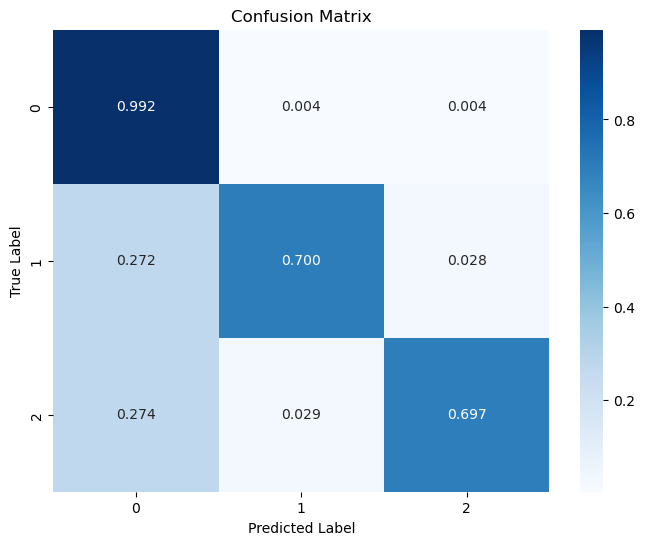

In [68]:
# Fungsi untuk membuat plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".3f", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Gunakan fungsi untuk plot confusion matrix
plot_confusion_matrix(y_valid, valid_preds, classes=['0', '1', '2'], normalize=True)

# <b>Adjust test data</b>

In [69]:
X_test  = test[select]

In [70]:
y_pred = stacking_model.predict(X_test)

In [71]:
sub = pd.read_csv(r'D:\penerimaan_negara_II\data\sample_submission.csv',delimiter=';')
sub['CustChannel'] = y_pred

In [72]:
# Menghitung jumlah masing-masing nilai dalam kolom "CustChannel"
value_counts = sub['CustChannel'].value_counts()

# Menghitung jumlah total pengamatan
total_count = len(sub)

# Menghitung presentase masing-masing nilai
percentage_counts = (value_counts / total_count) * 100

# Hasilnya adalah Series yang berisi presentase masing-masing nilai dalam bentuk persen
print(percentage_counts)

0    92.886789
1     3.660366
2     3.452845
Name: CustChannel, dtype: float64


In [73]:
sub['CustChannel'] = sub['CustChannel'].replace({0: 'Green', 1: 'Red', 2: 'Yellow'})

In [74]:
sub.to_csv('submission_stacking4boost_wshap7fitur_Hscodelength.csv', index=False)